In [1]:
!pip install gradio

  Created wheel for ffmpy: filename=ffmpy-0.3.0-py3-none-any.whl size=4709 sha256=4a2381e1cb36624fdac4cf933792367db0e702efc8e501d1a7a0cc84b5b1e259
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\13\e4\6c\e8059816e86796a597c6e6b0d4c880630f51a1fcfa0befd5e6
  Created wheel for python-multipart: filename=python_multipart-0.0.5-py3-none-any.whl size=31670 sha256=ee953088d54d8afd6b3bc8d92db6b7d51094dafbbbe560ce9ce678710942f563
  Stored in directory: c:\users\hp\appdata\local\pip\cache\wheels\2c\41\7c\bfd1c180534ffdcc0972f78c5758f89881602175d48a8bcd2c
Successfully built ffmpy python-multipart
  Attempting uninstall: yarl
    Found existing installation: yarl 1.6.3
    Uninstalling yarl-1.6.3:
      Successfully uninstalled yarl-1.6.3


In [2]:
# manggil library
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
import pickle
import tensorflow as tf
import gradio as gr
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing import image

In [3]:
# memberi label 
data_dir='./tamamdata-sendiri/'

categories = ['Huruf yang tidak dapat dirangkai ke depan', 'Titik yang membentuk lima bunyi huruf', 'Ekor yang dipotong', 'Ekor yg diluruskan', 'Dirangkai tanpa perubahan', 'Ekor yang diluruskan dan segitiga di tengah', 'Merangkai huruf fa qaf', 'Huruf kaf lam', 'Huruf mim ha', 'Sambung']

data = []

In [4]:
# inisialisasi data dan memberi label pada setiap data
def make_data ():
    for category in categories:
        path  = os.path.join(data_dir, category)
        label = categories.index(category)

        for img_name in os.listdir(path):
                image_path=os.path.join(path, img_name) 
                image=cv2.imread(image_path)

                try:
                    image = cv2.resize(image, (28,28))
                    image = np.array (image, dtype=np.float32)
                    data.append([image, label])
                except Exception as e:
                        pass


                
    print(len(data))
    
    pik=open('data-revisi.pickle', 'wb') #save data yang sudah diberi label 
    pickle.dump(data, pik)
    pik.close()

make_data ()

624


In [4]:
# fungsi load data dari pickle
def load_data():
    pick = open ('data-revisi.pickle', 'rb')
    data = pickle.load(pick)
    pick.close()
    
    np.random.shuffle(data)
    
    feature = []
    labels = []
    
    for img, label in data:
        feature.append(img)
        labels.append(label)
    
    feature = np.array(feature, dtype=np.float32)
    labels = np.array(labels)
    
    feature = feature/255.0
    
    return [feature, labels]

In [5]:
# load data
(feature, labels) = load_data()

In [6]:
# memisahkan dataset
# melakukan pengujian dengan parameter dengan train dataset yang berbeda
x_train, x_test, y_train, y_test= train_test_split(feature, labels, train_size = 0.8, test_size=0.2)

x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size= 0.2)

In [8]:
# buat arsitektur model CNN
input_layer = tf.keras.layers.Input([28,28,3])
conv1=tf.keras.layers.Conv2D(filters = 32, kernel_size=(5,5), padding='Same',
                      activation='relu')(input_layer)
pool1 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv1)
conv2 = tf.keras.layers.Conv2D(filters= 64, kernel_size=(3,3), padding='Same',
                              activation='relu')(pool1)
pool2 = tf.keras.layers.MaxPooling2D(pool_size=(2,2), strides=(2,2))(conv2)
conv3=tf.keras.layers.Conv2D(filters = 128, kernel_size=(5,5), padding='Same',
                      activation='relu')(pool2)
pool3 = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(conv3)
flt1 = tf.keras.layers.Flatten()(pool3)
dn1 = tf.keras.layers.Dense(512, activation='relu')(flt1)
out = tf.keras.layers.Dense(10, activation='softmax')(dn1)

model = tf.keras.Model(input_layer, out)

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [9]:
# train model
model_history = model.fit(x_train, y_train, batch_size = 100, 
                          epochs = 10,
                          validation_data = (x_val, y_val))


Epoch 1/10
4/4 [==============================] - 3s 821ms/step - loss: 2.2556 - accuracy: 0.1479 - val_loss: 2.2923 - val_accuracy: 0.1200
Epoch 2/10
4/4 [==============================] - 3s 687ms/step - loss: 2.1751 - accuracy: 0.2682 - val_loss: 2.2613 - val_accuracy: 0.1800
Epoch 3/10
4/4 [==============================] - 3s 758ms/step - loss: 2.0693 - accuracy: 0.3333 - val_loss: 2.1641 - val_accuracy: 0.2400
Epoch 4/10
4/4 [==============================] - 3s 643ms/step - loss: 1.8460 - accuracy: 0.3835 - val_loss: 1.8675 - val_accuracy: 0.2900
Epoch 5/10
4/4 [==============================] - 2s 582ms/step - loss: 1.5186 - accuracy: 0.4912 - val_loss: 1.5724 - val_accuracy: 0.4700
Epoch 6/10
4/4 [==============================] - 2s 585ms/step - loss: 1.2921 - accuracy: 0.5464 - val_loss: 1.2730 - val_accuracy: 0.5300
Epoch 7/10
4/4 [==============================] - 2s 590ms/step - loss: 1.2019 - accuracy: 0.6065 - val_loss: 1.6592 - val_accuracy: 0.3600
Epoch 8/10
4/4 [====

CNN Accuracy: 0.688


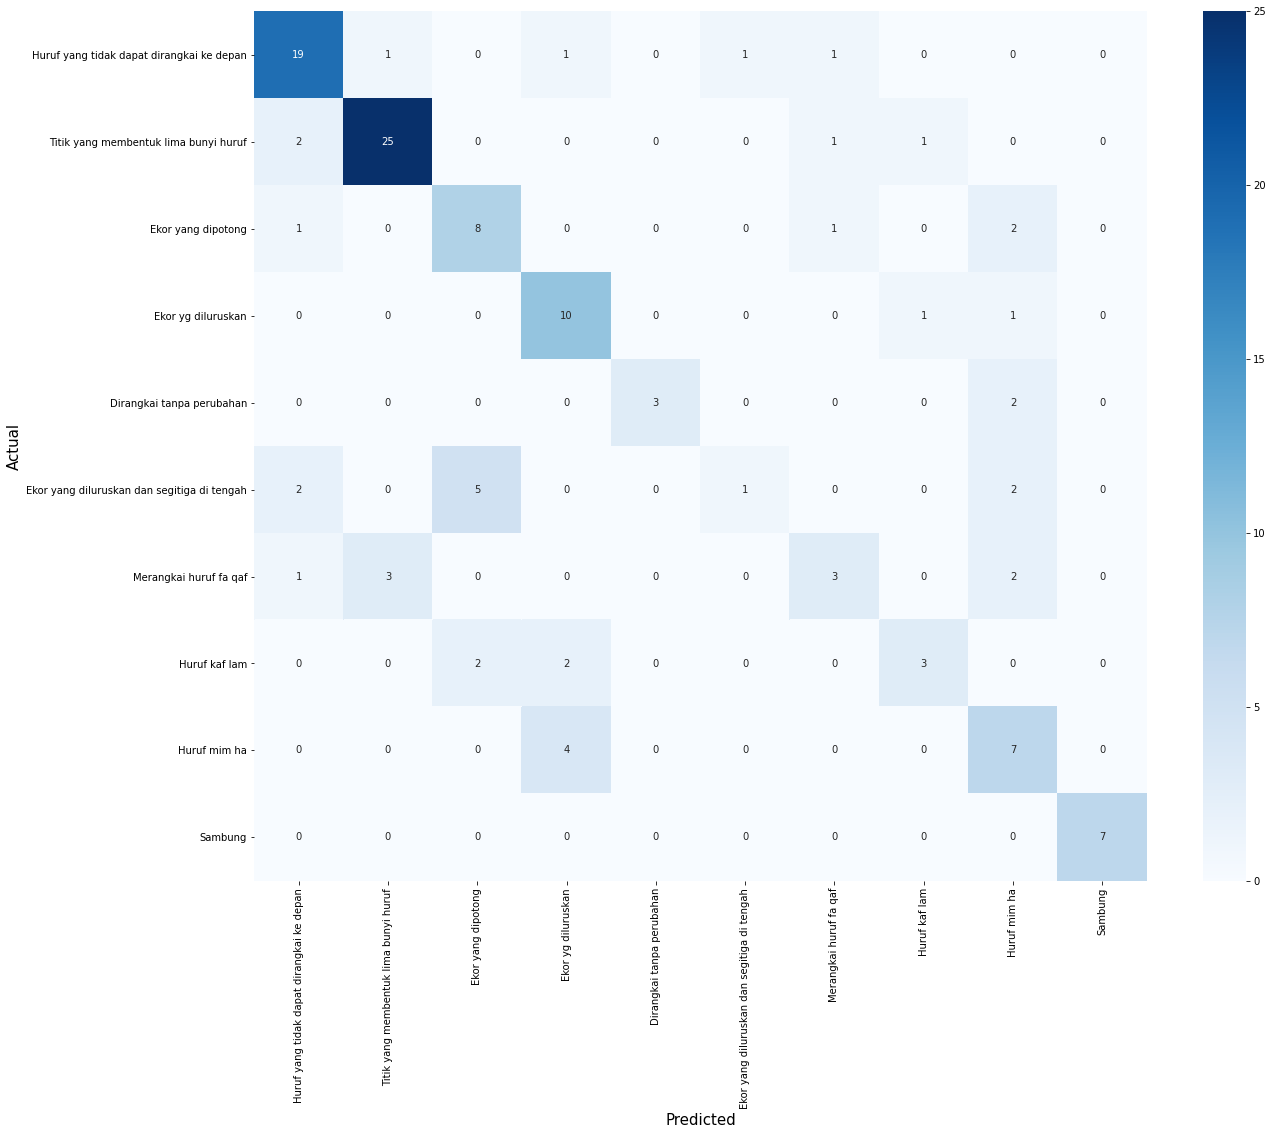

In [10]:
# menghitung accuracy menggunakan confusion matrix
from sklearn.metrics import accuracy_score, confusion_matrix
import seaborn as sns
ypred = model.predict(x_test)
cnn_accuracy = accuracy_score(y_test, ypred.argmax(axis=-1))
print("CNN Accuracy:",cnn_accuracy)
cnn_cn = confusion_matrix(y_test,ypred.argmax(axis=-1))
plt.subplots(figsize=(20,16))
sns.heatmap(cnn_cn,annot=True,fmt="1d",cmap="Blues",cbar=True,xticklabels=categories,yticklabels=categories)
plt.xlabel("Predicted",fontsize=15)
plt.ylabel("Actual",fontsize=15)
# plt.savefig('model60_e40.png')
plt.show()

In [11]:
from sklearn.metrics import classification_report
print(classification_report(y_test, ypred.argmax(axis=-1),target_names= categories))

                                             precision    recall  f1-score   support

  Huruf yang tidak dapat dirangkai ke depan       0.76      0.83      0.79        23
      Titik yang membentuk lima bunyi huruf       0.86      0.86      0.86        29
                         Ekor yang dipotong       0.53      0.67      0.59        12
                         Ekor yg diluruskan       0.59      0.83      0.69        12
                  Dirangkai tanpa perubahan       1.00      0.60      0.75         5
Ekor yang diluruskan dan segitiga di tengah       0.50      0.10      0.17        10
                     Merangkai huruf fa qaf       0.50      0.33      0.40         9
                              Huruf kaf lam       0.60      0.43      0.50         7
                               Huruf mim ha       0.44      0.64      0.52        11
                                    Sambung       1.00      1.00      1.00         7

                                   accuracy                    

Text(0.5, 1.0, 'Accuracy Curves')

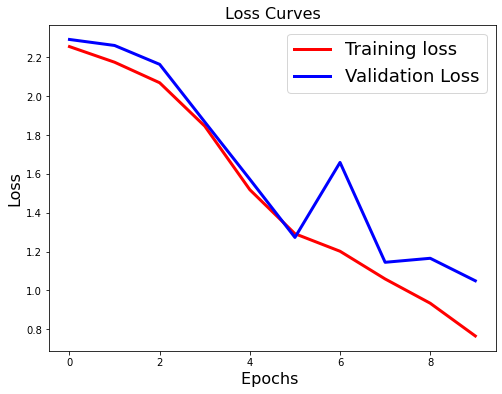

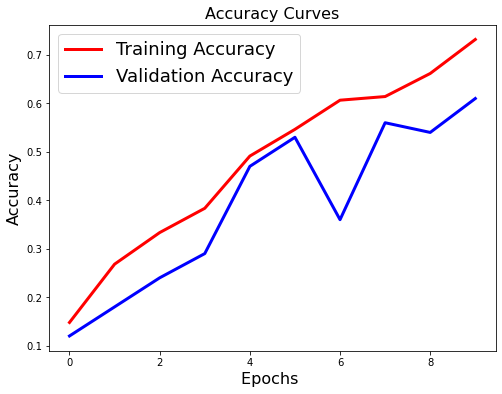

In [12]:
#Plot the Loss Curves
plt.figure(figsize=[8,6])
plt.plot(model_history.history['loss'],'r',linewidth=3.0)
plt.plot(model_history.history['val_loss'],'b',linewidth=3.0)
plt.legend(['Training loss', 'Validation Loss'],fontsize=18)
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.title('Loss Curves',fontsize=16)

#Plot the Accuracy Curves
plt.figure(figsize=[8,6]) 
plt.plot(model_history.history['accuracy'],'r',linewidth=3.0) 
plt.plot(model_history.history['val_accuracy'],'b',linewidth=3.0) 
plt.legend(['Training Accuracy', 'Validation Accuracy'],fontsize=18) 
plt.xlabel('Epochs ',fontsize=16) 
plt.ylabel('Accuracy',fontsize=16) 
plt.title('Accuracy Curves',fontsize=16)

In [13]:
model.save('tamam_model-revisi.h5')

In [7]:
#load model
model_load = tf.keras.models.load_model('tamam_model-revisi.h5')
print('loaded')

loaded


In [17]:
import random
data = ['Huruf yang tidak dapat dirangkai ke depan', 'Titik yang membentuk lima bunyi huruf', 'Ekor yang dipotong', 'Ekor yg diluruskan', 'Dirangkai tanpa perubahan', 'Ekor yang diluruskan dan segitiga di tengah', 'Merangkai huruf fa qaf', 'Huruf kaf lam', 'Huruf mim ha', 'Sambung']

print("Inputlah Kelas: ")
tugas=random.choice(data)
print(tugas)

Inputlah Kelas: 
Sambung


Tugas: 
Sambung
Jawaban: 
Sambung

BENAR


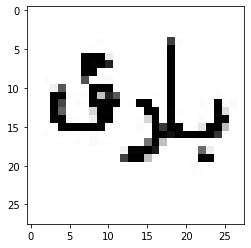

In [26]:

path = "hijaiyah/baroa.jpg"
img = image.load_img(path, target_size=(28,28))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)

images = np.vstack([x])
classes = model_load.predict(images, batch_size=11)


m = 0.00000
for category in range(len(categories)):
  if m < classes[0][category]:
    m = category
if m==0:
#   print("Kelas : Huruf yang tidak dapat dirangkai ke depan")
    kelas="Huruf yang tidak dapat dirangkai ke depan"
elif m==1:
#   print("Kelas : Titik yang membentuk lima bunyi huruf")
    kelas="Titik yang membentuk lima bunyi huruf"
elif m==2:
#   print("Kelas : Ekor yang dipotong")
    kelas="Ekor yang dipotong"
elif m==3:
#   print("Kelas : Ekor yg diluruskan")
    kelas="Ekor yg diluruskan"
elif m==4:
#   print("Kelas : Dirangkai tanpa perubahan")
     kelas="Dirangkai tanpa perubahan"
elif m==5:
#   print("Kelas : Ekor yang diluruskan dan segitiga di tengah")
     kelas="Ekor yang diluruskan dan segitiga di tengah"
elif m==6:
#   print("Kelas : Merangkai huruf fa qaf")     
     kelas="Merangkai huruf fa qaf"
elif m==7:
#   print("Kelas : Huruf kaf lam")
     kelas="Huruf kaf lam"
elif m==8:
#   print("Kelas : Huruf mim ha")
     kelas="Huruf mim ha"
elif m==9:
#   print("Kelas : Huruf mim ha")
     kelas="Sambung"    
else:
  print("Kelas : tidak terdeteksi")

print ("Tugas: ")
print(tugas)
print ("Jawaban: ")
print(kelas)
print()

if tugas == kelas:
    print("BENAR")
else:
    print("Salah, input lagi")

In [8]:
pred=model_load.predict
print(pred)
def predict_image(img):
  img_3d=img.reshape(-1,28,28)
  im_resize=img_3d/255.0
  prediction=model.predict(im_resize)
  pred=np.argmax(prediction)
  return pred

<bound method Model.predict of <tensorflow.python.keras.engine.functional.Functional object at 0x0000029839D6BFC8>>


In [9]:
iface = gr.Interface(predict_image, inputs="sketchpad", outputs="label")

In [ ]:
iface.launch(debug='True')

Running on local URL:  http://127.0.0.1:7860

To create a public link, set `share=True` in `launch()`.


Traceback (most recent call last):
  File "C:\Users\hp\.conda\envs\tensorflow\lib\site-packages\gradio\routes.py", line 276, in run_predict
    fn_index, raw_input, username, session_state, iterators
  File "C:\Users\hp\.conda\envs\tensorflow\lib\site-packages\gradio\blocks.py", line 760, in process_api
    result = await self.call_function(fn_index, inputs, iterator)
  File "C:\Users\hp\.conda\envs\tensorflow\lib\site-packages\gradio\blocks.py", line 672, in call_function
    block_fn.fn, *processed_input, limiter=self.limiter
  File "C:\Users\hp\.conda\envs\tensorflow\lib\site-packages\anyio\to_thread.py", line 32, in run_sync
    func, *args, cancellable=cancellable, limiter=limiter
  File "C:\Users\hp\.conda\envs\tensorflow\lib\site-packages\anyio\_backends\_asyncio.py", line 937, in run_sync_in_worker_thread
    return await future
  File "C:\Users\hp\.conda\envs\tensorflow\lib\site-packages\anyio\_backends\_asyncio.py", line 867, in run
    result = context.run(func, *args)
  Fil